# Max Deductible AB Test Calculation

In [1]:
# Python Libraries

import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as st
import pandas_profiling
import matplotlib.pyplot as plt
import matplotlib.style as style
from matplotlib import ticker as mtick
from matplotlib import rcParams
%matplotlib inline

style.use('seaborn-poster')
style.use('ggplot')
plt.rcParams['font.size'] = 12
plt.rcParams['font.weight'] = 'bold'

In [2]:
# Snowflake Import

from sqlalchemy import create_engine
from snowflake.sqlalchemy import URL

url = URL (
    account = 'tq01613.us-east-1',
    user = 'ron.nahshon@lemonade.com',
    password = 'R0n1@lemonade',
    database = 'lemonade',
    schema = 'public',
    warehouse = 'compute_wh',
    role='analyst',
)

engine = create_engine(url)
connection = engine.connect()

In [3]:
query = """        

SELECT
sf.user_id,
SUM(v.loss_and_lae_final) AS loss_and_lae,
SUM(v.daily_earned_premium) AS earned_premium,
ROUND(100.0 * SUM(v.loss_and_lae_final) / SUM(v.daily_earned_premium), 2) AS loss_ratio
    FROM loss_ratio_view AS v
        LEFT JOIN policies AS p
        ON v.policy_id = p.id
        LEFT JOIN users AS u
        ON u.id = p.user_id
        LEFT JOIN scores_flat AS sf
        ON sf.user_id = u.id
            WHERE sf.bucket = 10
            AND sf.endpoint = 'pre_quote'
            AND p.created_at BETWEEN '2019-02-01' AND '2019-02-28'
    GROUP BY 1
    ORDER BY 4 ASC
    
"""

df = pd.read_sql(query, connection)
print('Dataframe Shape', df.shape)
df.head()

# profile = pandas_profiling.ProfileReport(df)
# profile.to_file(outputfile="output.html")

Dataframe Shape (3735, 4)


,user_id,loss_and_lae,earned_premium,loss_ratio
0,1231438,0.394107,13.13690,3.0
1,1160731,0.629254,20.97512,3.0
2,1189092,0.853805,28.46018,3.0
3,1197452,1.236328,41.21094,3.0
4,358034,1.800000,60.00000,3.0


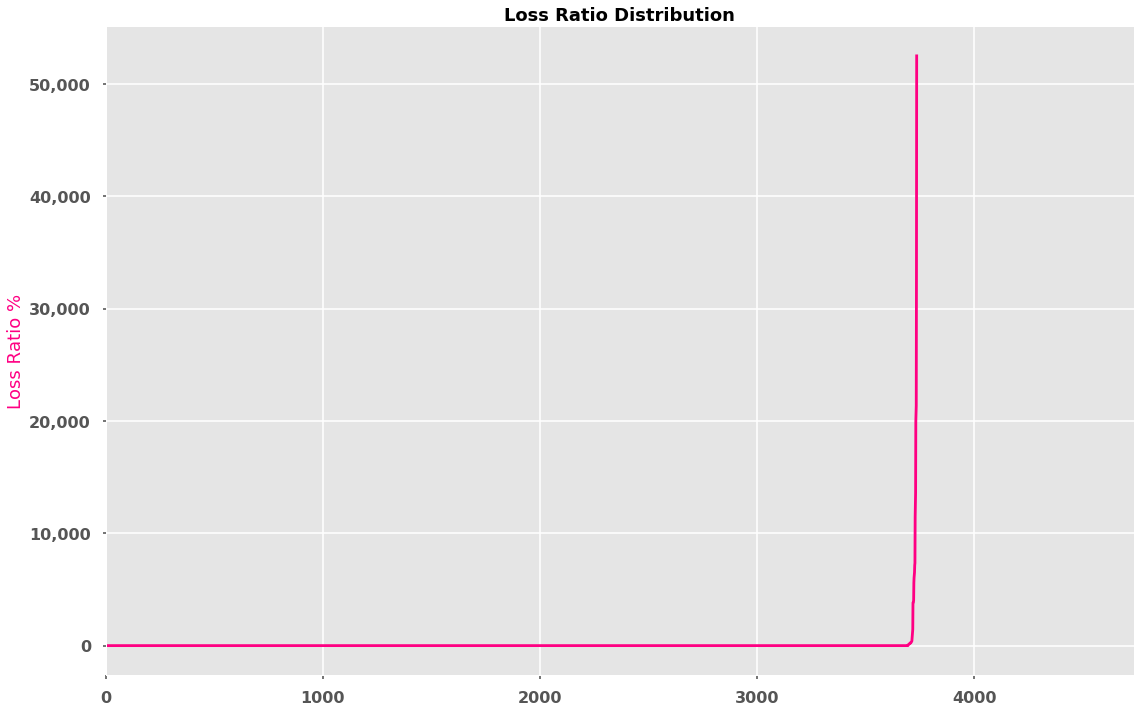

In [4]:
# All Loss Ratios

fig, ax = plt.subplots(figsize=(16,10))

ax.plot(np.arange(len(df)), df['loss_ratio'], color='#ff0083')
ax.set_title("Loss Ratio Distribution", fontsize=18, fontweight='bold')
ax.set_ylabel('Loss Ratio %', color='#ff0083', fontsize=18)
ax.yaxis.label.set_color('#ff0083')
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
ax.set_xlim(0,len(df)+1000)

plt.tight_layout()

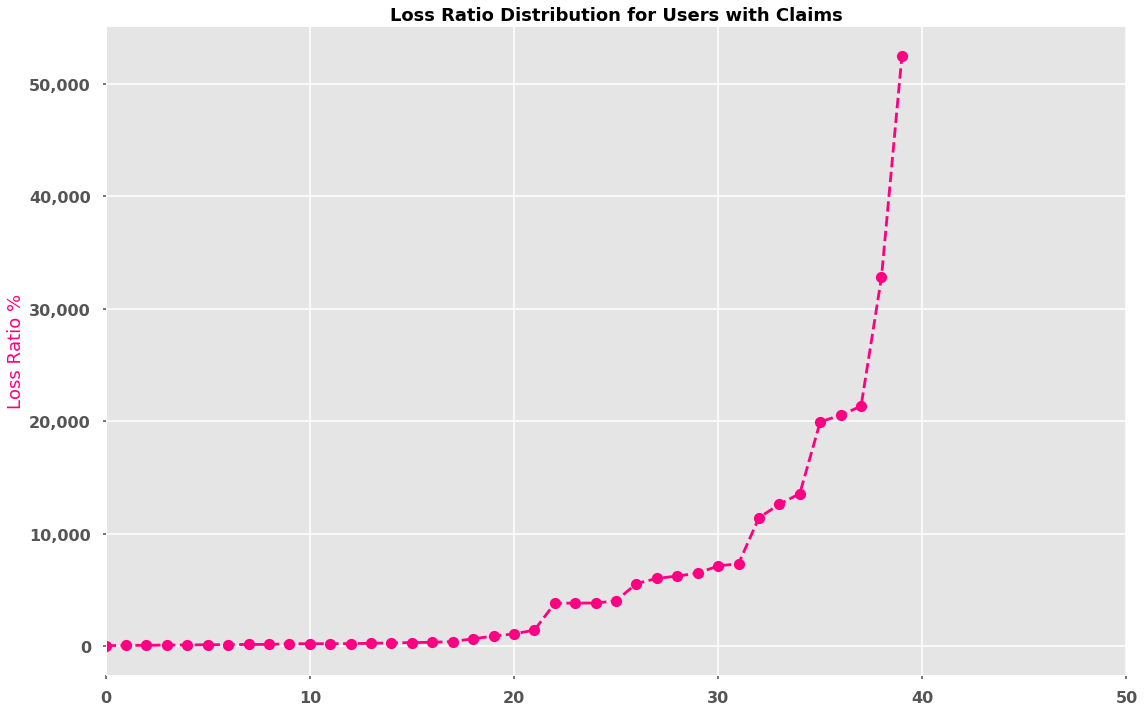

In [5]:
# Loss Ratios with Claims

df = df[df['loss_ratio'] > 3.0]

fig, ax = plt.subplots(figsize=(16,10))

ax.plot(np.arange(len(df)), df['loss_ratio'], color='#ff0083', marker='o', linestyle='--')
ax.set_title("Loss Ratio Distribution for Users with Claims", fontsize=18, fontweight='bold')
ax.set_ylabel('Loss Ratio %', color='#ff0083', fontsize=18)
ax.yaxis.label.set_color('#ff0083')
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
ax.set_xlim(0,len(df)+10)

plt.tight_layout()

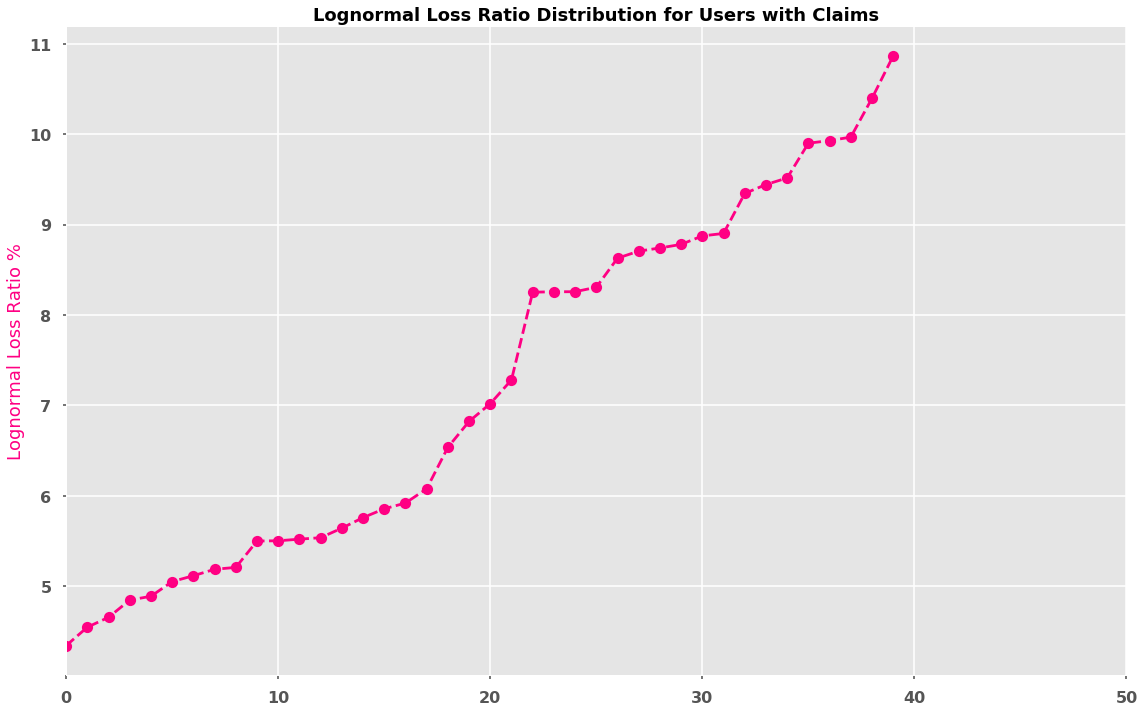

In [6]:
# Loss Ratios with Claims, Lognormal

df['loss_ratio'] = np.log(df['loss_ratio'])

fig, ax = plt.subplots(figsize=(16,10))

ax.plot(np.arange(len(df)), df['loss_ratio'], color='#ff0083', marker='o', linestyle='--')
ax.set_title("Lognormal Loss Ratio Distribution for Users with Claims", fontsize=18, fontweight='bold')
ax.set_ylabel('Lognormal Loss Ratio %', color='#ff0083', fontsize=18)
ax.yaxis.label.set_color('#ff0083')
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
ax.set_xlim(0,len(df)+10)

plt.tight_layout()

---